# Fine-Tuning a Hugging Face Model for Sentiment Analysis

In this notebook, we will walk through the process of fine-tuning a pre-trained model from Hugging Face for sentiment analysis using the IMDb dataset. This method can be adapted to fine-tune any model available on the Hugging Face Hub for a variety of NLP tasks.

For optimal performance, it's recommended to use Google Colab with a GPU (e.g., T4), as this significantly reduces training time and improves efficiency. While running on a laptop CPU is possible, it may be much slower and less efficient for fine-tuning larger models or datasets.

## Overview

Pre-trained models are general-purpose models that have been trained on large datasets. However, for specific tasks like sentiment analysis, we can fine-tune them on domain-specific datasets to improve performance. This notebook will guide you through the following steps:

1. Setting up Hugging Face tools and libraries.
2. Loading and preprocessing the IMDb dataset.
3. Fine-tuning a pre-trained model on the dataset.
4. Evaluating the model's performance before and after fine-tuning.

## Step 1: Install and Import Necessary Libraries

To begin, ensure that the required libraries are installed. Uncomment and run the following cell if needed:

In [1]:
# ! pip install transformers datasets

Now, we import the necessary libraries for loading datasets, handling the model, training, and evaluation:

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

## Step 2: Loading and Preparing the Dataset

Hugging Face's `datasets` library provides easy access to many NLP datasets, including IMDb. We'll load a subset of the IMDb dataset to speed up training and demonstrate the fine-tuning process.

In [3]:
# Load and shuffle the dataset
dataset = load_dataset("imdb", split="train").shuffle(seed=42).select(range(2000))
test_dataset = load_dataset("imdb", split="test").shuffle(seed=42).select(range(500))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Displaying a Few Examples from the Dataset

To better understand the data, let's take a look at a few examples from the training set:

In [4]:
# Define label mapping
label_mapping = {0: "Negative", 1: "Positive"}

# Display a few examples
for i in range(5):
    review_text = dataset[i]['text']
    label = dataset[i]['label']
    label_description = label_mapping[label]

    print(f"Example {i + 1}:")
    print(f"Review: {review_text}")
    print(f"Label: {label} ({label_description})")
    print("\n")


Example 1:
Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Label: 1 (Positive)


Example 2:
Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids call

---

## Step 3: Selecting a Pre-trained Model and Tokenizer from Hugging Face

One of the strengths of Hugging Face is the availability of numerous pre-trained models. We will use DistilBERT as an example, but this process works for any model available on the Hugging Face Hub.

In [5]:
# Specify the model name
model_name = "distilbert-base-uncased"

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Load the tokenizer corresponding to the model
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


---

## Step 4: Tokenizing the Dataset

Before training, we need to tokenize the text data. Tokenization converts raw text into a format that the model can understand (e.g., converting text to input IDs).

In [6]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Apply tokenization
tokenized_train_dataset = dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

---

## Step 5: Fine-Tuning the Model

Hugging Face makes fine-tuning easy with the `Trainer` class, which handles the training loop for you. We'll define the training parameters and set up the trainer:

### Defining Training Arguments

In [7]:
training_args = TrainingArguments(
    output_dir="./results",          # Directory for model checkpoints and logs
    eval_strategy="epoch",           # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save checkpoint at the end of each epoch
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Weight decay to prevent overfitting
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps
    save_total_limit=2,              # Only keep the last 2 checkpoints to save disk space
)

### Setting Up the Trainer

The `Trainer` class simplifies the process of training and evaluation. We'll use it to fine-tune the pre-trained model on our dataset.

In [8]:
trainer = Trainer(
    model=model,                            # The pre-trained model
    args=training_args,                     # Training arguments
    train_dataset=tokenized_train_dataset,  # Tokenized training dataset
    eval_dataset=tokenized_test_dataset     # Tokenized testing dataset
)

### Saving the Evaluation Results Before Fine-Tuning

Before we begin fine-tuning, we will evaluate the pre-trained model and save the results. This allows us to compare its performance with the fine-tuned model later.

In [9]:
# Evaluate the pre-trained model before fine-tuning
pre_fine_tune_eval = trainer.evaluate(eval_dataset=tokenized_test_dataset)

# Get predictions and true labels
predictions_before = np.argmax(trainer.predict(tokenized_test_dataset).predictions, axis=-1)
true_labels_before = np.array(tokenized_test_dataset['label'])

### Fine-Tuning the Model

Now, we'll fine-tune the model on the IMDb dataset.

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,0.213800,0.268800,0.004500
2,0.154200,0.355143,0.004500
3,0.031800,0.348638,0.004500


TrainOutput(global_step=375, training_loss=0.22704859177271525, metrics={'train_runtime': 314.8731, 'train_samples_per_second': 19.055, 'train_steps_per_second': 1.191, 'total_flos': 794804391936000.0, 'train_loss': 0.22704859177271525, 'epoch': 3.0})

### Saving the Evaluation Results After Fine-Tuning

This step allows us to compare the model's performance after fine-tuning with its pre-fine-tuning performance.

In [11]:
# Evaluate the fine-tuned model
post_fine_tune_eval = trainer.evaluate(eval_dataset=tokenized_test_dataset)

# Get predictions and true labels
predictions_after = np.argmax(trainer.predict(tokenized_test_dataset).predictions, axis=-1)
true_labels_after = np.array(tokenized_test_dataset['label'])

---

## Step 6: Comparing Performance Before and After Fine-Tuning

Now that we have evaluated the model both before and after fine-tuning, let's compare the performance:

In [12]:
# Print evaluation results
print("\nComparison of pre-fine-tuning and post-fine-tuning results:")
print(f"Pre-fine-tuning evaluation: {pre_fine_tune_eval}")
print(f"Post-fine-tuning evaluation: {post_fine_tune_eval}")


Comparison of pre-fine-tuning and post-fine-tuning results:
Pre-fine-tuning evaluation: {'eval_loss': 0.7027134299278259, 'eval_model_preparation_time': 0.0045, 'eval_runtime': 11.866, 'eval_samples_per_second': 42.137, 'eval_steps_per_second': 2.697}
Post-fine-tuning evaluation: {'eval_loss': 0.3486384153366089, 'eval_model_preparation_time': 0.0045, 'eval_runtime': 7.7756, 'eval_samples_per_second': 64.304, 'eval_steps_per_second': 4.115, 'epoch': 3.0}


The **evaluation loss** (`eval_loss`) decreased after fine-tuning, indicating improved model performance in classifying test samples. Additionally, the **evaluation runtime** (`eval_runtime`) was shorter, showing the model became more efficient in processing the test data.

### Visualizing the Confusion Matrix

We'll also visualize the confusion matrix to understand how well the model performed on each class:

Confusion Matrix Before Fine-Tuning:


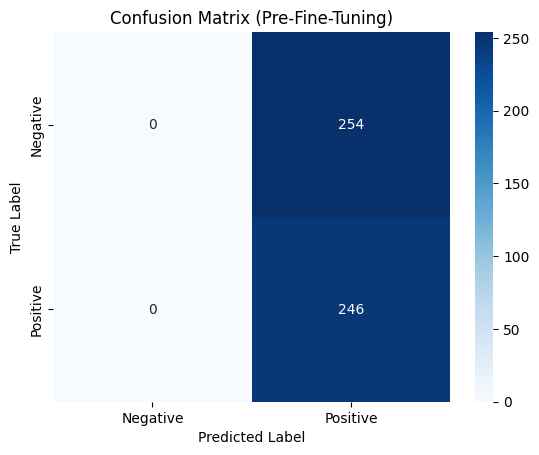

Confusion Matrix After Fine-Tuning:


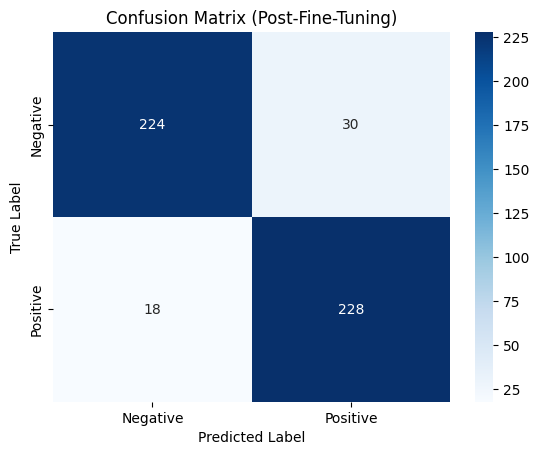

In [13]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices
print("Confusion Matrix Before Fine-Tuning:")
plot_confusion_matrix(true_labels_before, predictions_before, "Confusion Matrix (Pre-Fine-Tuning)")

print("Confusion Matrix After Fine-Tuning:")
plot_confusion_matrix(true_labels_after, predictions_after, "Confusion Matrix (Post-Fine-Tuning)")

### Generating Classification Reports

We can also generate classification reports to see metrics like precision, recall, and F1-score before and after fine-tuning:

In [14]:
from sklearn.metrics import classification_report

# Print classification report before and after fine-tuning
print("\nClassification Report Before Fine-Tuning:")
print(classification_report(true_labels_before, predictions_before, target_names=["Negative", "Positive"]))

print("\nClassification Report After Fine-Tuning:")
print(classification_report(true_labels_after, predictions_after, target_names=["Negative", "Positive"]))


Classification Report Before Fine-Tuning:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       254
    Positive       0.49      1.00      0.66       246

    accuracy                           0.49       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.24      0.49      0.32       500


Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

    Negative       0.93      0.88      0.90       254
    Positive       0.88      0.93      0.90       246

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After fine-tuning, the model improves in predicting positive reviews, with higher precision, recall, and F1-score, though the overall accuracy sees only a slight increase.

## Conclusion

This notebook demonstrates the process of fine-tuning a pre-trained Hugging Face model for sentiment analysis using the IMDb dataset. The same approach can be applied to other NLP tasks, such as named entity recognition or text classification, by selecting appropriate models and datasets.

Fine-tuning enhances model performance on specific tasks by allowing it to adapt to the nuances of the target dataset, achieving better results than general-purpose pre-trained models.